In [1]:
%load_ext autoreload

In [2]:
! pip install tqdm
! pip install scipy

In [3]:
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import torch
from tqdm.auto import tqdm

from DSA.dmd import DMD
from DSA.stats import *


/Users/mitchellostrow/opt/anaconda3/envs/dsapublic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate Data

In [4]:
def L63(vec, t, sigma=10, rho=28, beta=8/3):
    x, y, z = vec[0], vec[1], vec[2]
    d = np.zeros(3)
    d[0] = sigma*(y - x)
    d[1] = x*(rho - z) - y
    d[2] = x*y - beta*z

    return d

dynamics_dict = {
    'Lorenz63': L63
}

def generate_data(
      system, # options: ['Lorenz63']
      dt=0.01, # time step, in seconds
      end_time=20, # end time of the simulation, in seconds
      transient=0, # transient to drop
      num_init_conds=1, # number of initial conditions to generate
      init_cond_mean=0, # mean of initial condition
      init_cond_std=1, # standard deviation of initial condition
      system_kwargs={}, # keyword arguments to be provided to the system dynamics
      expand_dim=None, # if provided, the dimension to expande the system to
      expansion_nonlinearity=np.tanh, # nonlinearity to be applied to the expansion
      verbose=False, # whether to track progress
  ):

  if system == 'Lorenz63':
    n = 3

  t_eval = np.arange(0, end_time, dt)
  init_conds = np.random.randn(num_init_conds, n)*init_cond_std + init_cond_mean
  pts = np.zeros((num_init_conds, len(t_eval), n))
  for i, init_cond in tqdm(enumerate(init_conds), total=num_init_conds, disable=not verbose):
    sol = solve_ivp(lambda t, x: dynamics_dict[system](x, t, **system_kwargs), [0, end_time], init_cond, t_eval=t_eval, rtol=1e-12)
    pts[i] = sol.y.T

  pts = pts[:, int(transient/dt):]

  if expand_dim is not None:
    W = np.random.randn(expand_dim, n)
    pts = (W@pts.transpose(0, 2, 1)).transpose(0, 2, 1)
    pts = (pts - pts.mean())/pts.std()
    pts = expansion_nonlinearity(pts)

  return pts

In [5]:
# Lorenz63 kwargs
L63_kwargs = dict(
  system = 'Lorenz63',

  dt=0.1, # time step, in seconds
  end_time=2000, # end time of the simulation, in seconds
  transient=200, # transient to drop, in seconds

  # dt=0.01, # time step, in seconds
  # end_time=50, # end time of the simulation, in seconds
  # transient=20, # transient to drop, in seconds

  num_init_conds=1, # number of initial conditions to generate
  init_cond_mean=0, # mean of initial condition
  # init_cond_std=1, # standard deviation of initial condition
  # system_kwargs={}, # keyword arguments to be provided to the system dynamics
  expand_dim=None, # if provided, the dimensi,on to expande the system to
  expansion_nonlinearity=np.tanh, # nonlinearity to be applied to the expansion,

  verbose=True
)

system_kwargs = L63_kwargs

pts = generate_data(
  **system_kwargs
)

100%|██████████| 1/1 [00:10<00:00, 10.17s/it]


In [6]:
pts = pts[0]
pts = pts - pts.mean(axis=0)

# Test

In [7]:
dmd = DMD(pts[:10000].reshape(4, 2500, -1), n_delays=150, verbose=True)

In [8]:
dmd.fit(rank=300)

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 



In [11]:
preds = dmd.predict()
preds.shape

torch.Size([4, 2500, 3])

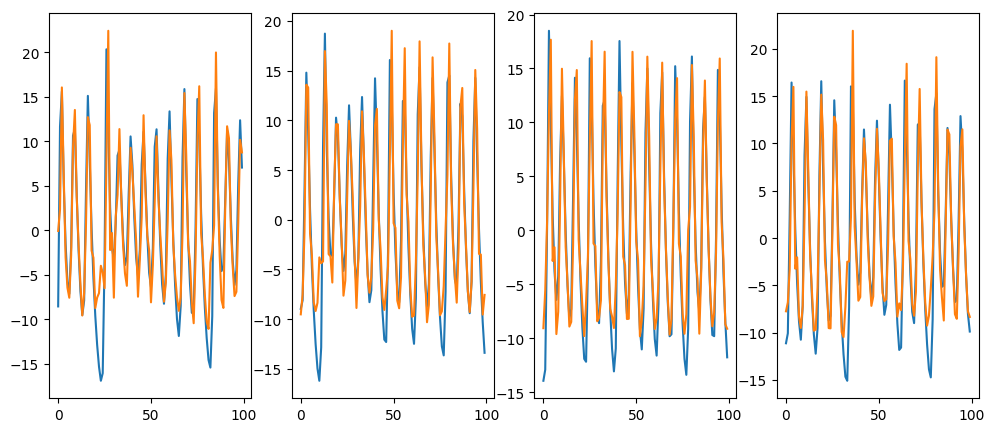

In [12]:
pred_start = (dmd.n_delays - 1)*dmd.delay_interval + 1
pred_length = 100
dim = 2
fig, axs = plt.subplots(1, preds.shape[0], figsize=(12, 5))
for i in range(preds.shape[0]):
    ax = axs[i]
    ax.plot(dmd.data[i, pred_start:pred_start + pred_length, dim])
    ax.plot(preds[i, pred_start:pred_start + pred_length, dim])
plt.show()

In [13]:
%%time
compute_all_stats(dmd.data[:, pred_start:], preds[:, pred_start:], rank=dmd.rank, norm=True)

CPU times: user 3.12 ms, sys: 3.67 ms, total: 6.79 ms
Wall time: 16.1 ms


{'MAE': 2.5213026358451924,
 'MASE': 0.5486326863713192,
 'MSE': 12.68645078434762,
 'R2': 0.8358856973464476,
 'Correl': 0.9128922820091248,
 'AIC': 8.923584201972321}

In [14]:
test_data = pts[10000:]
test_data = test_data.reshape(4, 2000, 3)

In [15]:
preds = dmd.predict(test_data)

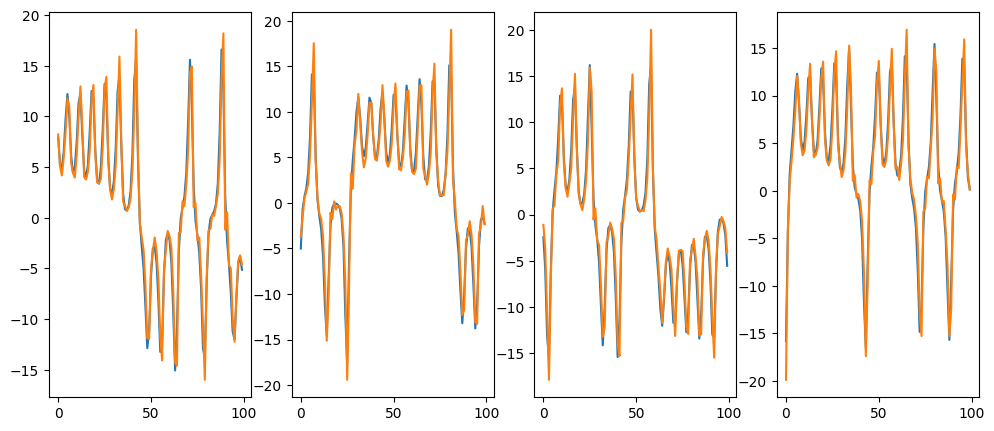

In [ ]:
pred_start = (dmd.n_delays - 1)*dmd.delay_interval + 1
pred_length = 100
fig, axs = plt.subplots(1, test_data.shape[0], figsize=(12, 5))
for i in range(test_data.shape[0]):
    ax = axs[i]
    ax.plot(test_data[i, pred_start:pred_start + pred_length, 0])
    ax.plot(preds[i, pred_start:pred_start + pred_length, 0])
plt.show()

In [16]:
%%time
compute_all_stats(test_data[:, pred_start:], preds[:, pred_start:], rank=dmd.rank, norm=True)

CPU times: user 1.77 ms, sys: 729 µs, total: 2.5 ms
Wall time: 1.68 ms


{'MAE': 2.5992292470271003,
 'MASE': 0.5639169094725991,
 'MSE': 13.477207460761758,
 'R2': 0.8256031498871144,
 'Correl': 0.9070751070976257,
 'AIC': 10.70919812055686}